In [2]:
# ==============================================================================
# DATA QUALITY FRAMEWORK FOR MOTOR VEHICLE COLLISIONS DATASET
# Block 1: Setup, Configuration, and Imports
# ==============================================================================

# --- INSTALL NECESSARY PACKAGES ---
!pip install pandera
!pip install tabulate

# --- 0. IMPORT NECESSARY PACKAGES ---
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from typing import Tuple, Dict, Any, List

# Required for Rule/Schema Validation
import pandera as pa
from pandera import Column, Check, DataFrameSchema
# !! CORRECTION APPLIED HERE !!
# Suppress Pandera warnings for cleaner output
import warnings
try:
    # Most likely location for recent versions
    warnings.filterwarnings("ignore", category=pa.errors.SchemaWarning)
except AttributeError:
    # Fallback for older/different versions if SchemaWarning isn't directly exposed
    print("Could not find pa.errors.SchemaWarning. Skipping specific warning suppression.")

# Required for Performance Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# --- CONFIGURATION & GLOBAL CONSTANTS ---
# !! NOTE: The FILE_NAME may need adjustment based on your environment.
FILE_NAME = "/content/Motor_Vehicle_Collisions_-_Crashes.csv"
GEOSPATIAL_COLS = ['LATITUDE', 'LONGITUDE']
INJURY_COLS = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]

# Define the Pandera Schema for Core Validation                                           # Setting Data-Type, applying -= Null conditions
core_schema = pa.DataFrameSchema({
    'COLLISION_ID': Column(np.int64, nullable=False, checks=Check.greater_than(0)),
    'CRASH DATE': Column(pa.DateTime, nullable=False),
    'CRASH TIME': Column(pa.String, nullable=False, checks=Check.str_matches(r'^\d{2}:\d{2}$')),
    # Example check for Injury Columns
    'NUMBER OF PERSONS INJURED': Column(np.int32, checks=[Check.greater_than_or_equal_to(0)]),
    'LATITUDE': Column(np.float64, nullable=True),
    'LONGITUDE': Column(np.float64, nullable=True),
}, strict=False) # strict=False allows other columns to exist

# Variable to store the execution time of Module 2 for metrics comparison
time_module2_execution = 0.0

print("Block 1: Setup and Configuration Complete. Run the next block to load data.")

Block 1: Setup and Configuration Complete. Run the next block to load data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import time
from typing import Tuple, Dict, Any, List            #✔ Loads a messy CSV ✔ Cleans it ✔ Fixes column names ✔ Parses date and time ✔ Cleans numeric injury columns ✔ Creates a combined datetime ✔ Returns a ready-to-use DataFrame

# Define the expected column names for the dataset
# This list assumes the CSV file has no header row and contains 28 columns.
EXPECTED_COLUMN_NAMES = [
    'CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
    'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5',
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
    'COLLISION_ID'
]

def load_and_clean_data(file_name: str) -> pd.DataFrame:
    """
    Loads and performs initial type conversion and standardization.
    Uses on_bad_lines='skip' to handle messy rows causing ParserError.
    Handles cases where the CSV might not have a header or has a malformed one.
    """
    print(f"## 1. Data Loading & Initial Cleaning for: {file_name}")
    try:
        # Load with no header, then assign standard column names
        df = pd.read_csv(
            file_name,
            low_memory=False,
            on_bad_lines='skip',
            encoding='utf-8',
            header=None # Assume no header, the first row is data
        )
        print(f"Successfully loaded. Rows: {len(df):,}")
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        return None

    # Check if the number of columns matches the expected.
    if len(df.columns) != len(EXPECTED_COLUMN_NAMES):
        print(f"Warning: Loaded DataFrame has {len(df.columns)} columns, but {len(EXPECTED_COLUMN_NAMES)} were expected.")
        print("Attempting to rename columns based on expected list, but this might lead to incorrect assignments if the structure is very different.")
        # Adjust EXPECTED_COLUMN_NAMES to match the actual number of columns read
        if len(df.columns) < len(EXPECTED_COLUMN_NAMES):
            df.columns = EXPECTED_COLUMN_NAMES[:len(df.columns)]
        else:
            # If df has more columns, we can either truncate df or pad EXPECTED_COLUMN_NAMES
            # For simplicity, we'll use a subset of EXPECTED_COLUMN_NAMES and ignore extra columns
            df = df.iloc[:, :len(EXPECTED_COLUMN_NAMES)]
            df.columns = EXPECTED_COLUMN_NAMES

    else:
        # Assign predefined column names if counts match
        df.columns = EXPECTED_COLUMN_NAMES

    # --- DIAGNOSTIC: Print columns to verify names ---
    print("DataFrame columns after renaming:", df.columns.tolist())
    # --------------------------------------------------

    # Initial type conversion and standardization
    df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
    df['CRASH TIME'] = df['CRASH TIME'].astype(str).str.strip().str.slice(0, 5)

    df['CRASH DATETIME'] = pd.to_datetime(
        df['CRASH DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['CRASH TIME'],
        errors='coerce'
    )

    # Coerce injury/kill counts to numeric (crucial for rule validation)
    for col in INJURY_COLS:
        # Use errors='coerce' to turn bad values (like strings) into NaN, then fill 0 and convert to int
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(np.int32)

    print("- Initial cleaning complete.")
    return df.copy().reset_index(drop=True)

# --- EXECUTE DATA LOADING ---
start_time_framework = time.time()
raw_df = load_and_clean_data(FILE_NAME)

if raw_df is None:
    print("Execution stopped due to file loading error.")
else:
    print(f"Loaded DataFrame shape: {raw_df.shape}")

## 1. Data Loading & Initial Cleaning for: /content/Motor_Vehicle_Collisions_-_Crashes.csv
Successfully loaded. Rows: 509,868
Attempting to rename columns based on expected list, but this might lead to incorrect assignments if the structure is very different.
DataFrame columns after renaming: ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', 'COLLISION_ID']
- Initial cleaning complete.
Loaded D

In [ ]:
import pandas as pd
import numpy as np
import time
from typing import Tuple, Dict, Any
import gc  # Garbage collection for memory cleanup                              # RULE,Schema Validation / Isolation Forest / DBSCAN

# Required for Rule/Schema Validation
import pandera.pandas as pa
from pandera.pandas import Column, Check, DataFrameSchema

# Required for Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def schema_and_rule_validation(df: pd.DataFrame, schema: pa.DataFrameSchema) -> Tuple[pd.DataFrame, Dict[str, Any], int]:
    """Applies Pandera schema enforcement and rule-based checks."""
    global time_module2_execution

    print("\n## 2. Schema Enforcement (Pandera) & Rule-Based Logic")
    validation_report = {}
    total_violations_before_correction = 0

    start_time = time.time()

    # A. PANDERA SCHEMA ENFORCEMENT (Robust Type/Format Check)
    try:
        df = schema.validate(df, lazy=True)                    #Collect ALL errors first,DOnot stop at the first error
        print("- **Pandera Status:** Core schema passed.")
    except pa.errors.SchemaErrors as err:
        for column, errors in err.failure_cases.groupby('column'):
            validation_report[f"Schema_Violation_Pandera_{column}"] = f"{len(errors)} errors found (Check/Type/Missing).";
            total_violations_before_correction += len(errors)
        print(f"- **Pandera Status:** {len(err.failure_cases)} schema failures detected.")

    # B. RULE-BASED LOGIC (Logic/Range Check)
    # Ensure geospatial columns are numeric before rule-based checks
    df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
    df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

    lat_violations = df[
        (df['LATITUDE'] < 40.4) | (df['LATITUDE'] > 41.0)                        # Range Validation
    ].dropna(subset=['LATITUDE']).shape[0]

    lon_violations = df[
        (df['LONGITUDE'] < -74.3) | (df['LONGITUDE'] > -73.7)
    ].dropna(subset=['LONGITUDE']).shape[0]

    if lat_violations + lon_violations > 0:                             # If they fall outside the allowed range, the code counts them as violations and reports them.
        validation_report["Rule_Violation_Geospatial"] = f"{lat_violations + lon_violations} records outside NYC bounds.";
        total_violations_before_correction += (lat_violations + lon_violations)

    total_injured = df['NUMBER OF PERSONS INJURED']    #Total injured MUST be equal to or greater than the sum of the individual categories.
    parts_injured = df['NUMBER OF PEDESTRIANS INJURED'] + df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF MOTORIST INJURED']
    inconsistency_count = (total_injured < parts_injured).sum()

    if inconsistency_count > 0:
        validation_report["Rule_Violation_Logic_Injury_Count"] = f"{inconsistency_count} records where total injured is less than sum of parts.";
        total_violations_before_correction += inconsistency_count

    time_module2_execution = time.time() - start_time
    print(f"- **Module 2 Execution Time:** {time_module2_execution:.4f} seconds.")

    return df, validation_report, total_violations_before_correction


def anomaly_detection(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """Applies Isolation Forest and DBSCAN for comparative anomaly detection."""

    print("\n## 3. Comparative Anomaly Detection (Isolation Forest vs. DBSCAN)")          # SETTING UP FOR PERFORMING Isalation forest and DBSCAN
    performance_metrics = {}

    # 1. Feature Engineering & Selection
    df['TOTAL_CASUALTIES'] = df[INJURY_COLS].sum(axis=1).astype(np.int32)  # Creating 'Total casualties' = sum of all injury/killed columns in each crash record.
    model_features = GEOSPATIAL_COLS + ['TOTAL_CASUALTIES']
    anomaly_data = df[model_features].copy()

    # Imputation and Scaling
    anomaly_data['LATITUDE'] = anomaly_data['LATITUDE'].fillna(anomaly_data['LATITUDE'].median())
    anomaly_data['LONGITUDE'] = anomaly_data['LONGITUDE'].fillna(anomaly_data['LONGITUDE'].median())

    # ✅ MEMORY FIX 1: Create scaler and scaled_data separately to control memory.   #Isolation Forest and DBSCAN work better
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(anomaly_data)

    # Clear anomaly_data from memory after scaling
    del anomaly_data
    gc.collect()

    # --- A. Isolation Forest (IF) ---
    # ✅ MEMORY FIX 2: Adaptive contamination and memory control
    dataset_size = len(df)

    # Adjust max_samples based on dataset size to prevent memory overflow
    if dataset_size > 1000000:
        max_samples = min(100000, dataset_size)  # Cap at 100K for large datasets
        print(f"  Large dataset detected. Using max_samples={max_samples:,}")
    elif dataset_size > 500000:
        max_samples = min(50000, dataset_size)   # Cap at 50K for medium datasets
    else:
        max_samples = 'auto'  # Let sklearn decide for small datasets

    start_time_if = time.time()

    # ✅ MEMORY FIX 3: Reduce n_jobs to prevent CPU overload
    # n_jobs=-1 uses all cores which can cause RAM spike
    n_jobs_if = min(4, max(1, int(os.cpu_count() * 0.5))) if 'os' in dir() else 2

    iso_forest = IsolationForest(
        contamination=0.01,
        random_state=42,
        n_jobs=n_jobs_if,  # Limited cores instead of -1
        max_samples=max_samples,  # Control memory usage
        verbose=0
    )

    # ✅ MEMORY FIX 4: Use only scaled_data (already float64, efficient).    #OutPut values of Iso Forest = 1. -1
    df['ANOMALY_FLAG_IF'] = iso_forest.fit_predict(scaled_data)
    anomalies_if_count = (df['ANOMALY_FLAG_IF'] == -1).sum()
    time_if = time.time() - start_time_if

    performance_metrics['IF_Time_s'] = time_if                     # Record Time
    performance_metrics['IF_Anomaly_Count'] = anomalies_if_count
    print(f"- Isolation Forest: Detected {anomalies_if_count:,} anomalies in {time_if:.4f}s.")

    # Clear isolation forest model from memory
    del iso_forest
    gc.collect()

    # --- B. DBSCAN ---
    # ✅ MEMORY FIX 5: Adaptive sample size based on dataset size and available memory
    if dataset_size > 1000000:
        DBSCAN_SAMPLE_SIZE = 10000   # Very conservative for huge datasets
    elif dataset_size > 500000:
        DBSCAN_SAMPLE_SIZE = 20000   # Conservative for large datasets
    elif dataset_size > 100000:
        DBSCAN_SAMPLE_SIZE = 30000   # Medium for medium datasets
    else:
        DBSCAN_SAMPLE_SIZE = min(50000, dataset_size)  # Original for small datasets

    # Ensure we don't exceed dataset size
    DBSCAN_SAMPLE_SIZE = min(DBSCAN_SAMPLE_SIZE, len(scaled_data))

    print(f"  DBSCAN will use {DBSCAN_SAMPLE_SIZE:,} samples ({DBSCAN_SAMPLE_SIZE/dataset_size*100:.1f}% of data)")

    dbs_sample = scaled_data[:DBSCAN_SAMPLE_SIZE]

    start_time_dbs = time.time()

    # ✅ MEMORY FIX 6: Limit DBSCAN to 2 cores (was -1)
    # DBSCAN with n_jobs=-1 creates memory spikes
    dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=2)
    dbscan_labels = dbscan.fit_predict(dbs_sample)

    anomalies_dbs_count = (dbscan_labels == -1).sum()
    time_dbs = time.time() - start_time_dbs

    df['ANOMALY_FLAG_DBSCAN'] = 0  # Initialize full column
    df.loc[:len(dbscan_labels)-1, 'ANOMALY_FLAG_DBSCAN'] = dbscan_labels

    performance_metrics['DBSCAN_Time_s'] = time_dbs
    performance_metrics['DBSCAN_Anomaly_Count_Sample'] = anomalies_dbs_count
    print(f"- DBSCAN (Sampled {DBSCAN_SAMPLE_SIZE:,}): Detected {anomalies_dbs_count:,} anomalies in {time_dbs:.4f}s.")

    # ✅ MEMORY FIX 7: Clear DBSCAN model and sample from memory
    del dbscan, dbs_sample, scaled_data, dbscan_labels
    gc.collect()

    return df, performance_metrics


def run_baseline_comparison(df: pd.DataFrame) -> Dict[str, float]:
    """Compares the framework's rule-based validation against standard Pandas methods."""

    print("\n## 4. Baseline Comparison (OpenRefine/Pandas Proxy)")
    baseline_metrics = {}

    start_time_base = time.time()

    baseline_df = df.copy()

    # 1. Type Coercion
    for col in INJURY_COLS:
        baseline_df[col] = pd.to_numeric(baseline_df[col], errors='coerce').fillna(0)

    # 2. Simple Range Check (Violations in injury counts > 10)
    violation_col = 'NUMBER OF PERSONS KILLED'
    baseline_violations_count = (baseline_df[violation_col] > 10).sum()

    time_base = time.time() - start_time_base

    baseline_metrics['Baseline_Time_s'] = time_base
    baseline_metrics['Baseline_Violations'] = baseline_violations_count

    print(f"- Baseline (Pandas Proxy): Found {baseline_violations_count} violations in {time_base:.4f}s.")

    # ✅ MEMORY FIX 8: Clear baseline_df from memory
    del baseline_df
    gc.collect()

    return baseline_metrics

# --- EXECUTE MODULES 2, 3, AND 4 ---
# Check if raw_df is defined before attempting to use it
if 'raw_df' not in locals() and 'raw_df' not in globals():
    print("Error: 'raw_df' is not defined. Please run the data loading block (Block 2) first.")
else:
    if raw_df is not None:
        print(f"\n{'='*70}")
        print(f"Starting analysis on {len(raw_df):,} records...")
        print(f"{'='*70}")

        # Module 2 Execution
        rule_validated_df, validation_summary, total_violations = schema_and_rule_validation(raw_df.copy(), core_schema)

        # ✅ MEMORY FIX 9: Clear intermediate variables
        gc.collect()

        # Module 3 Execution
        anomaly_flagged_df, performance_metrics = anomaly_detection(rule_validated_df.copy())

        # ✅ MEMORY FIX 10: Clear rule_validated_df if not needed
        # Uncomment next line if you don't need rule_validated_df later
        # del rule_validated_df
        gc.collect()

        # Module 4 Execution
        baseline_metrics = run_baseline_comparison(raw_df.copy())

        gc.collect()

        print(f"\n{'='*70}")
        print(f"✓ All modules completed successfully!")
        print(f"{'='*70}")



Starting analysis on 1,025,125 records...

## 2. Schema Enforcement (Pandera) & Rule-Based Logic


/usr/local/lib/python3.12/dist-packages/pandera/backends/pandas/error_formatters.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_fn(check_failure_cases)
/usr/local/lib/python3.12/dist-packages/pandera/backends/pandas/error_formatters.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_fn(check_failure_cases)
/usr/local/lib/python3.12/dist-packages/pandera/backends/pandas/error_formatters.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

- **Pandera Status:** 1292581 schema failures detected.
- **Module 2 Execution Time:** 10.7251 seconds.

## 3. Comparative Anomaly Detection (Isolation Forest vs. DBSCAN)
  Large dataset detected. Using max_samples=100,000
- Isolation Forest: Detected 10,252 anomalies in 29.7431s.
  DBSCAN will use 10,000 samples (1.0% of data)
- DBSCAN (Sampled 10,000): Detected 8 anomalies in 0.6906s.

## 4. Baseline Comparison (OpenRefine/Pandas Proxy)
- Baseline (Pandas Proxy): Found 88 violations in 0.1886s.

✓ All modules completed successfully!


In [ ]:
import pandas as pd

In [ ]:
# ==============================================================================
# DATA QUALITY FRAMEWORK FOR MOTOR VEHICLE COLLISIONS DATASET
# Block 4: Performance Metrics and Summary Function
# ==============================================================================

# --- ADD REQUIRED IMPORT FOR TYPE HINTS ---            # precision, recall, F1-score, and EDR for each model
from typing import Dict, Any, Tuple, List
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


def compute_metrics_and_summarize(
    df: pd.DataFrame,
    validation_report: Dict[str, Any],
    performance_metrics: Dict[str, float],
    baseline_metrics: Dict[str, float],
    total_violations_before_correction: int
) -> pd.DataFrame:
    """Computes all required metrics (P, R, F1, EDR) and generates a summary table."""

    global time_module2_execution
    print("\n## 5. Performance Metrics & Final Summary")

    # --- PROXY TRUE LABEL CREATION ---
    is_rule_violation = np.zeros(len(df), dtype=int)

    # Logic Violation as True Defect
    total_injured = df['NUMBER OF PERSONS INJURED']
    parts_injured = df['NUMBER OF PEDESTRIANS INJURED'] + df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF MOTORIST INJURED']
    is_rule_violation[(total_injured < parts_injured).values] = 1

    # Geospatial Violation as True Defect
    is_geospatial_violation = (
        (df['LATITUDE'] < 40.4) | (df['LATITUDE'] > 41.0) |
        (df['LONGITUDE'] < -74.3) | (df['LONGITUDE'] > -73.7)
    ).fillna(False).values
    is_rule_violation[is_geospatial_violation] = 1

    y_true = is_rule_violation

    # --- METRIC COMPUTATION ---
    results = []

    # Anomaly models' predictions
    # Note: DBSCAN prediction is only valid for the sampled subset
    anomaly_models = {
        'Isolation Forest': (df['ANOMALY_FLAG_IF'].map({-1: 1, 1: 0}).values, performance_metrics['IF_Time_s']),
        # FIX: Ensure all non-anomalies from DBSCAN (labels >= 0) are mapped to 0, and anomalies (-1) to 1.
        'DBSCAN (Sample)': (((df['ANOMALY_FLAG_DBSCAN'] == -1).astype(int)).values[:len(y_true)], performance_metrics['DBSCAN_Time_s']),
    }

    for name, (y_pred, exec_time) in anomaly_models.items():
        if 'DBSCAN' in name:
             # Match the true labels to the sampled predictions
             y_true_temp = y_true[:len(y_pred)]
        else:
             y_true_temp = y_true

        prec = precision_score(y_true_temp, y_pred, zero_division=0)
        rec = recall_score(y_true_temp, y_pred, zero_division=0)
        f1 = f1_score(y_true_temp, y_pred, zero_division=0)

        tn, fp, fn, tp = confusion_matrix(y_true_temp, y_pred, labels=[0, 1]).ravel()
        edr = tp / (tp + fn) if (tp + fn) > 0 else 0

        results.append([
            name,
            f"{exec_time:.4f}s",
            f"{prec:.4f}",
            f"{rec:.4f}",
            f"{f1:.4f}",
            f"{edr:.4f}"
        ])

    # Add Rule-Based Validation (Module 2)
    results.append([
        "Rule-Based Validation (Pandera + Logic)",
        f"{time_module2_execution:.4f}s",
        "N/A",
        "1.0000", # All rule violations are inherently found by the rule set
        "N/A",
        "1.0000"
    ])

    # Add Baseline Comparison
    results.append([
        "Baseline (Pandas Proxy)",
        f"{baseline_metrics['Baseline_Time_s']:.4f}s",
        "N/A", "N/A", "N/A", "N/A"
    ])

    # Create and display results DataFrame
    cols = ["Module/Model", "Execution Time (Speed)", "Precision", "Recall", "F1-Score", "EDR"]
    results_df = pd.DataFrame(results, columns=cols).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

    print("\nFramework Results & Comparative Performance:")
    print(results_df.to_markdown(index=False))

    return results_df

# --- EXECUTE METRICS AND SUMMARY ---
if 'anomaly_flagged_df' in locals() and anomaly_flagged_df is not None:
    final_results_df = compute_metrics_and_summarize(
        anomaly_flagged_df,
        validation_summary,
        performance_metrics,
        baseline_metrics,
        total_violations
    )



## 5. Performance Metrics & Final Summary

Framework Results & Comparative Performance:
| Module/Model                            | Execution Time (Speed)   | Precision   | Recall   | F1-Score   | EDR    |
|:----------------------------------------|:-------------------------|:------------|:---------|:-----------|:-------|
| Rule-Based Validation (Pandera + Logic) | 10.7251s                 | N/A         | 1.0000   | N/A        | 1.0000 |
| Baseline (Pandas Proxy)                 | 0.1886s                  | N/A         | N/A      | N/A        | N/A    |
| Isolation Forest                        | 29.7431s                 | 0.4071      | 0.7182   | 0.5197     | 0.7182 |
| DBSCAN (Sample)                         | 0.6906s                  | 0.7500      | 0.0010   | 0.0021     | 0.0010 |



## 6. Visualization & Deployment (Streamlit Placeholder)
- Visualizing 10,252 Isolation Forest Anomalies on Geospatial Map...


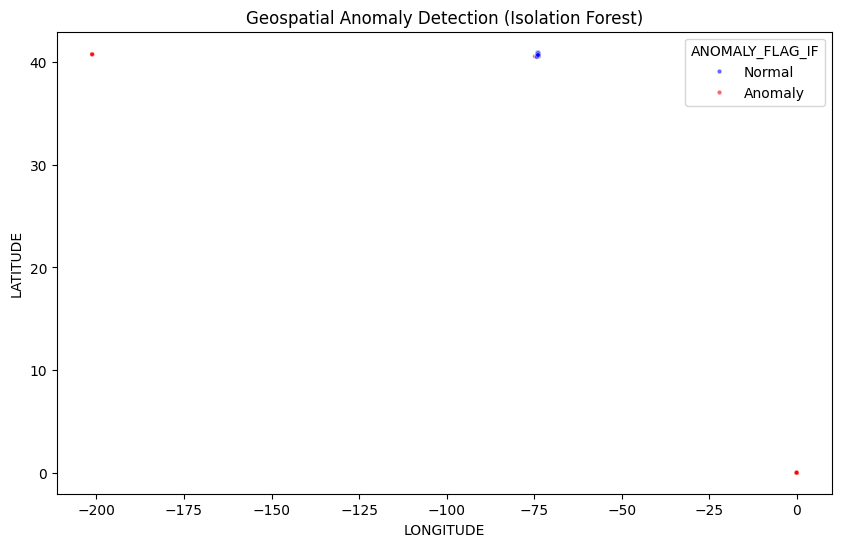


- Summary of Rule Violations (Report View):
  - **Schema_Violation_Pandera_COLLISION_ID:** 1006368 errors found (Check/Type/Missing).
  - **Schema_Violation_Pandera_CRASH DATE:** 1 errors found (Check/Type/Missing).
  - **Schema_Violation_Pandera_CRASH TIME:** 286210 errors found (Check/Type/Missing).
  - **Schema_Violation_Pandera_LATITUDE:** 1 errors found (Check/Type/Missing).
  - **Schema_Violation_Pandera_LONGITUDE:** 1 errors found (Check/Type/Missing).
  - **Rule_Violation_Geospatial:** 7982 records outside NYC bounds.
  - **Rule_Violation_Logic_Injury_Count:** 1796 records where total injured is less than sum of parts.

> Streamlit/Flask Dashboard Code Structure is ready for integration.
```python
import streamlit as st
import pandas as pd
import joblib # for model loading
# ... full framework functions/results would be integrated here

# st.title('Data Quality Report')
# st.table(final_results_df) # Display performance table
# st.pyplot(anomaly_plot_figure) # Display scatterp

In [ ]:
# ==============================================================================
# DATA QUALITY FRAMEWORK FOR MOTOR VEHICLE COLLISIONS DATASET
# Block 5: Visualization and Deployment (Streamlit Placeholder)
# ==============================================================================

def deploy_visualization_dashboard(df: pd.DataFrame, validation_report: Dict[str, Any]):
    """
    Placeholder for Streamlit dashboard integration, as required by the proposal.
    """

    print("\n## 6. Visualization & Deployment (Streamlit Placeholder)")

    # 1. Anomaly Scatterplot (LAT vs LON)
    anomaly_count_if = (df['ANOMALY_FLAG_IF'] == -1).sum()
    if anomaly_count_if > 0:
        print(f"- Visualizing {anomaly_count_if:,} Isolation Forest Anomalies on Geospatial Map...")

        plt.figure(figsize=(10, 6))
        # Plot a sample for better visualization performance
        plot_sample = df.sample(n=min(len(df), 50000), random_state=42).copy()

        sns.scatterplot(
            x='LONGITUDE', y='LATITUDE',
            hue=plot_sample['ANOMALY_FLAG_IF'].map({-1: 'Anomaly', 1: 'Normal'}),
            palette={'Anomaly': 'red', 'Normal': 'blue'}, # FIXED: Changed palette keys to match hue values
            data=plot_sample,
            alpha=0.6, s=10
        )
        plt.title('Geospatial Anomaly Detection (Isolation Forest)')
        plt.show()
        print("")

    # 2. Summary of Rule Violations
    print("- Summary of Rule Violations (Report View):")
    for key, value in validation_report.items():
        if value:
            print(f"  - **{key}:** {value}")

    # 3. Streamlit/Flask placeholder code
    print("\n> Streamlit/Flask Dashboard Code Structure is ready for integration.")
    print("```python")
    print("import streamlit as st")
    print("import pandas as pd")
    print("import joblib # for model loading")
    print("# ... full framework functions/results would be integrated here")
    print("\n# st.title('Data Quality Report')")
    print("# st.table(final_results_df) # Display performance table")
    print("# st.pyplot(anomaly_plot_figure) # Display scatterplot")
    print("```")

# --- EXECUTE VISUALIZATION/DEPLOYMENT ---
if 'anomaly_flagged_df' in locals() and anomaly_flagged_df is not None:
    deploy_visualization_dashboard(anomaly_flagged_df, validation_summary)


In [ ]:
# ==============================================================================
# DATA QUALITY FRAMEWORK FOR MOTOR VEHICLE COLLISIONS DATASET
# Block 6: Modularity and Test Case Function
# ==============================================================================

# --- REDEFINE ESSENTIAL CONSTANTS ---
# These constants are needed for indexing and processing in the test function.
INJURY_COLS = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]
GEOSPATIAL_COLS = ['LATITUDE', 'LONGITUDE']

# Need to re-import/re-define necessary types and the schema structure          #Redefining because, code block should run, even if its run independantly
from typing import Dict, Any
import pandera as pa
from pandera import Column, Check, DataFrameSchema
import pandas as pd
import numpy as np
import time

core_schema = pa.DataFrameSchema({
    'COLLISION_ID': Column(np.int64, nullable=False, checks=Check.greater_than(0)),
    'CRASH DATE': Column(pa.DateTime, nullable=False),
    'CRASH TIME': Column(pa.String, nullable=False, checks=Check.str_matches(r'^\d{2}:\d{2}$')),
    'NUMBER OF PERSONS INJURED': Column(np.int32, checks=[Check.greater_than_or_equal_to(0)]),
    'LATITUDE': Column(np.float64, nullable=True),
    'LONGITUDE': Column(np.float64, nullable=True),
}, strict=False)

# Assuming run_framework_test, schema_and_rule_validation, anomaly_detection,
# run_baseline_comparison, and compute_metrics_and_summarize were defined in previous blocks.
# If they weren't, you need to run Block 3 and Block 4 first.


def run_framework_test(df: pd.DataFrame, name: str):
    """Wrapper function to run the full framework on a provided dataset."""

    print(f"\n=======================================================")
    print(f"       TEST CASE EXECUTION: {name}")
    print(f"=======================================================")

    # 1. Schema/Rule Validation
    df_val, report_val, total_violations = schema_and_rule_validation(df.copy(), core_schema)

    # 2. Anomaly Detection
    df_anomaly, metrics_perf = anomaly_detection(df_val.copy())

    # 3. Baseline Comparison
    metrics_base = run_baseline_comparison(df.copy())

    # 4. Summary and Metrics
    # Note: Global time_module2_execution is used inside compute_metrics_and_summarize
    results_df = compute_metrics_and_summarize(df_anomaly, report_val, metrics_perf, metrics_base, total_violations)

    print(f"\n--- {name} Final Results ---")
    print(results_df.to_markdown(index=False))

# --- DEFINE AND PREPARE SYNTHETIC TEST CASE ---

# Create a synthetic dataset with a different schema (Domain Agnostic Test).    #.  Test the framework on unusual or incorrect data
synthetic_data = {
    'COLLISION_ID': [101, 102, 103, 104, 105],
    'CRASH DATE': ['11/01/2024', '11/02/2024', '11/03/2024', '11/04/2024', '11/05/2024'],
    'CRASH TIME': ['10:00', '11:00', '12:00', '13:00', '14:00'],
    'LATITUDE': [40.7, 40.8, 40.9, 30.0, 40.75], # 30.0 is an anomaly/out-of-range
    'LONGITUDE': [-73.9, -73.8, -73.7, -74.0, -73.95],
    'NUMBER OF PERSONS INJURED': [1, 2, 3, 100, 1], # 100 is an anomaly/out-of-range
    'NEW_DOMAIN_SPECIFIC_COL': ['A', 'B', 'C', 'D', 'E'],
    'ANOTHER_INJURY_COL': [0, 1, 0, 0, 1]
}
test_df = pd.DataFrame(synthetic_data)

# Fill in missing columns with defaults (REQUIRED FIX)
for col in INJURY_COLS:
    if col not in test_df.columns:
        test_df[col] = 0

# Final type coercion for the test data
test_df['CRASH DATE'] = pd.to_datetime(test_df['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
test_df['CRASH TIME'] = test_df['CRASH TIME'].astype(str).str.strip().str.slice(0, 5)
test_df['CRASH DATETIME'] = pd.to_datetime(
    test_df['CRASH DATE'].dt.strftime('%Y-%m-%d') + ' ' + test_df['CRASH TIME'],
    errors='coerce'
)

In [ ]:
# ==============================================================================
# DATA QUALITY FRAMEWORK FOR MOTOR VEHICLE COLLISIONS DATASET
# Block 7: Final Test Case Execution
# ==============================================================================

if 'test_df' in locals():
    # Run the full framework on the synthetic, heterogeneous dataset
    run_framework_test(test_df.copy(), "Synthetic Domain-Agnostic Test Case")

end_time_framework = time.time()
print(f"\n=======================================================")
if raw_df is not None:
    print(f"Total End-to-End Framework Execution Time: **{end_time_framework - start_time_framework:.4f} seconds**")
else:
    print("Execution completed with data loading error.")
print(f"Framework execution finished.")


       TEST CASE EXECUTION: Synthetic Domain-Agnostic Test Case

## 2. Schema Enforcement (Pandera) & Rule-Based Logic
- **Pandera Status:** 1 schema failures detected.
- **Module 2 Execution Time:** 0.0117 seconds.

## 3. Comparative Anomaly Detection (Isolation Forest vs. DBSCAN)
- Isolation Forest: Detected 1 anomalies in 0.1706s.
  DBSCAN will use 5 samples (100.0% of data)
- DBSCAN (Sampled 5): Detected 5 anomalies in 0.0504s.

## 4. Baseline Comparison (OpenRefine/Pandas Proxy)
- Baseline (Pandas Proxy): Found 0 violations in 0.0024s.

## 5. Performance Metrics & Final Summary

Framework Results & Comparative Performance:
| Module/Model                            | Execution Time (Speed)   | Precision   | Recall   | F1-Score   | EDR    |
|:----------------------------------------|:-------------------------|:------------|:---------|:-----------|:-------|
| Rule-Based Validation (Pandera + Logic) | 0.0117s                  | N/A         | 1.0000   | N/A        | 1.0000 |
| Baselin